# Original model for classifying radio modulation 
## Purely built using only Pytorch and run on GPU

In [1]:
#TODO: write tutorial for building model (non-quantized) using only pytorch. 
#This is only for demonstration purposes, showing the structure of the model
#This model is not used in any stages of the transformation
#Instead the Brevitas quantized model will be used for transformation

In [51]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm
import time

In [30]:
# Using cuda 
assert torch.cuda.is_available(), 'Cuda not available'
gpu = 'cuda'

# The RadioML 2021 Dataset <a id='load_dataset'></a>

The dataset comes in hdf5 format and exhibits the following structure:
- 27 modulations
- 26 SNRs per modulation (-20 dB through +30 dB in steps of 2)
- 4096 frames per modulation-SNR combination
- 1024 complex time-series samples per frame
- Samples as floating point in-phase and quadrature (I/Q) components, resulting in a (1024,2) frame shape
- 2.875.392 frames in total
- Value is in int8 [-128, 127]

You can get dataset here:
https://opendata.deepsig.io/datasets/2021.07/RADIOML_2021_07_INT8.tar.gz

In [ ]:
# Check if dataset is present
import os.path
dataset_path = "datasets/RADIOML_2021_07_INT8.hdf5"
os.path.isfile(dataset_path)

Extracting dataset and organize into a Mod-SNR-Sample combination order 1D array.

This is a modified version of this notebook (with changes to accomodate with our dataset): https://github.com/Xilinx/brevitas-radioml-challenge-21/blob/main/sandbox/notebooks/training_and_evaluation.ipynb

In [6]:
# Prepare data loader
from torch.utils.data import Dataset, DataLoader
import h5py

class radioml_21_dataset(Dataset):
    def __init__(self, dataset_path):
        super(radioml_21_dataset, self).__init__()
        h5_file = h5py.File(dataset_path,'r')
        self.data = h5_file['X']
        self.mod = np.argmax(h5_file['Y'], axis=1) # comes in one-hot encoding
        self.snr = h5_file['Z'][:,0]
        self.len = self.data.shape[0]

        self.mod_classes = [
                "OOK",
                "4ASK",
                "8ASK",
                "BPSK",
                "QPSK",
                "8PSK",
                "16PSK",
                "32PSK",
                "16APSK",
                "32APSK",
                "64APSK",
                "128APSK",
                "16QAM",
                "32QAM",
                "64QAM",
                "128QAM",
                "256QAM",
                "AM-SSB-WC",
                "AM-SSB-SC",
                "AM-DSB-WC",
                "AM-DSB-SC",
                "FM",
                "GMSK",
                "OQPSK",
                "BFSK",
                "4FSK",
                "8FSK",
            ]
        self.num_classes=len(self.mod_classes)
        # print(np.unique(self.snr))
        # print(self.data.shape)
        # print(np.min(self.data),'   ',np.max(self.data),'  ',self.data.dtype)
        self.snr_classes = np.arange(-20., 32., 2) # -20dB to 30dB, with step of 2 --> 26 snrs

        # do not touch this seed to ensure the prescribed train/test split!
        np.random.seed(2021)

        train_indices = []
        test_indices = []
        for mod in range(0, len(self.mod_classes)): # all modulations (0 to 26)
            for snr_idx in range(0, 26): # all SNRs (0 to 25 = -20dB to +30dB)
                # raw dataset holds frames strictly ordered by modulation and SNR
                # We order the dataset to each mod-snr pair combination for better access of each frame
                # Specifically we divide the dataset into 27 mods group,
                #   and for each group we divide into 26 SNRs,
                # For each modulation-snr pair combination, we have 4096 frames. (27*26*4096 = 2875392)
                # For better analogy, its basically a triple for-loop, with the outer most loop being 27 mods,
                #                                                           then the middle being 26 SNRs,
                #                                                           then inner most being 4096 samples
                # Basically [0[0[0...4095] ...25]...26] with a length of 2875392
                start_idx = 26*4096*mod + 4096*snr_idx 
                indices_subclass = list(range(start_idx, start_idx+4096))
                
                # 90%/10% training/test split, applied evenly for each mod-SNR pair
                split = int(np.ceil(0.1 * 4096)) 
                np.random.shuffle(indices_subclass)
                train_indices_subclass = indices_subclass[split:]
                test_indices_subclass = indices_subclass[:split]
                
                # you could train on a subset of the data, e.g. based on the SNR
                # here we use all available training samples
                if snr_idx >= 0:
                    train_indices.extend(train_indices_subclass)
                test_indices.extend(test_indices_subclass)
                
        self.train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
        self.test_sampler = torch.utils.data.SubsetRandomSampler(test_indices)

    def __getitem__(self, idx):
        # transpose frame into Pytorch channels-first format (NCL = -1,2,1024)
        return self.data[idx].transpose(), self.mod[idx], self.snr[idx]

    def __len__(self):
        return self.len

dataset = radioml_21_dataset(dataset_path) 

print('Value range: ', np.min(dataset.data),'   ',np.max(dataset.data),'  ',dataset.data.dtype) #The total range of int8 is [-127,128]
print('Total mods: ',dataset.num_classes)
print('Number of SNRs: ',len(dataset.snr_classes))
print('Number of frames per each SNR-Modulation combination: ',dataset.data.shape[0]/(dataset.num_classes*len(dataset.snr_classes)))
print('SNRs: ',dataset.snr_classes,' \n')
print('Total size: ',dataset.data.shape)
print('Training set size: ',len(dataset.train_sampler))
print('Test/Val set size: ',len(dataset.test_sampler))

Value range:  -112     127    int8
Total mods:  27
Number of SNRs:  26
Number of frames per each SNR-Modulation combination:  4096.0
SNRs:  [-20. -18. -16. -14. -12. -10.  -8.  -6.  -4.  -2.   0.   2.   4.   6.
   8.  10.  12.  14.  16.  18.  20.  22.  24.  26.  28.  30.]  

Total size:  (2875392, 1024, 2)
Training set size:  2587572
Test/Val set size:  287820


## Visualize an example frame

Modulation: 8FSK, SNR: 30.0 dB, Index: 2871419


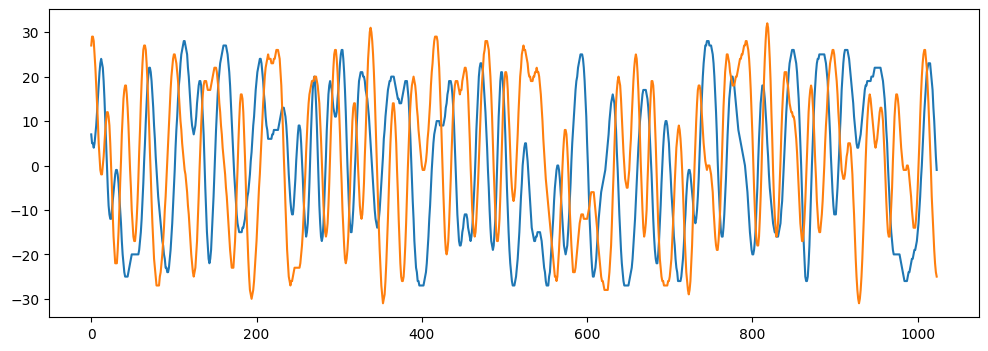

In [7]:
# Inspect a frame
mod = 26 # 0 to 26
snr_idx = 25 # 0 to 25 = -20dB to +30dB
sample = 123 # 0 to 4095
#-----------------------#
idx = 26*4096*mod + 4096*snr_idx + sample
data, mod, snr = dataset.data[idx], dataset.mod[idx], dataset.snr[idx]
plt.figure(figsize=(12,4))
plt.plot(data)
print("Modulation: %s, SNR: %.1f dB, Index: %d" % (dataset.mod_classes[mod], snr, idx))

# Build the VGG-10 model

This model is built purely in pytorch, meaning this model has not been quantized. 
The structure of the model follows the VGG-10 model described in this paper [Over-the-Air Deep Learning Based Radio Signal Classification](https://arxiv.org/pdf/1712.04578.pdf).

The model should have: 

- 7 convolutional blocks, 

- a flatten layer,

- 2 linear blocks 

- 1 final linear layer to make decision which of the 27 modulation

In [12]:
from torch import nn

# Adjustable hyperparameters
filters_conv = 64
filters_dense = 128

# Setting seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

model_class = nn.Sequential(

    nn.Conv1d(2, filters_conv, 3, padding=1),
    nn.BatchNorm1d(filters_conv),
    nn.ReLU(),
    nn.MaxPool1d(2),

    nn.Conv1d(filters_conv, filters_conv, 3, padding=1),
    nn.BatchNorm1d(filters_conv),
    nn.ReLU(),
    nn.MaxPool1d(2),

    nn.Conv1d(filters_conv, filters_conv, 3, padding=1),
    nn.BatchNorm1d(filters_conv),
    nn.ReLU(),
    nn.MaxPool1d(2),

    nn.Conv1d(filters_conv, filters_conv, 3, padding=1),
    nn.BatchNorm1d(filters_conv),
    nn.ReLU(),
    nn.MaxPool1d(2),

    nn.Conv1d(filters_conv, filters_conv, 3, padding=1),
    nn.BatchNorm1d(filters_conv),
    nn.ReLU(),
    nn.MaxPool1d(2),

    nn.Conv1d(filters_conv, filters_conv, 3, padding=1),
    nn.BatchNorm1d(filters_conv),
    nn.ReLU(),
    nn.MaxPool1d(2),

    nn.Conv1d(filters_conv, filters_conv, 3, padding=1),
    nn.BatchNorm1d(filters_conv),
    nn.ReLU(),
    nn.MaxPool1d(2),
    
    nn.Flatten(),

    nn.Linear(filters_conv*8, filters_dense),
    nn.BatchNorm1d(filters_dense),
    nn.ReLU(),

    nn.Linear(filters_dense, filters_dense),
    nn.BatchNorm1d(filters_dense),
    nn.ReLU(),

    nn.Linear(filters_dense, 27, bias=True),
)
model=model_class

import torchinfo
print(torchinfo.summary(model_class,input_size=(1,2,1024)))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 27]                   --
├─Conv1d: 1-1                            [1, 64, 1024]             448
├─BatchNorm1d: 1-2                       [1, 64, 1024]             128
├─ReLU: 1-3                              [1, 64, 1024]             --
├─MaxPool1d: 1-4                         [1, 64, 512]              --
├─Conv1d: 1-5                            [1, 64, 512]              12,352
├─BatchNorm1d: 1-6                       [1, 64, 512]              128
├─ReLU: 1-7                              [1, 64, 512]              --
├─MaxPool1d: 1-8                         [1, 64, 256]              --
├─Conv1d: 1-9                            [1, 64, 256]              12,352
├─BatchNorm1d: 1-10                      [1, 64, 256]              128
├─ReLU: 1-11                             [1, 64, 256]              --
├─MaxPool1d: 1-12                        [1, 64, 128]              --
├─C

# Train the model

Defining train, test, displaying loss plot graph function

In [46]:
from sklearn.metrics import accuracy_score

def train(model, train_loader, optimizer, criterion):
    losses = []
    # ensure model is in training mode
    model.train()    

    for (inputs, target, snr) in tqdm(train_loader, desc="Training Batches", leave=False):   
        #Converting inputs to float because for some reason torch read inputs as char type
        inputs = inputs.to(gpu).float() 
        target = target.to(gpu)#.float()
        #print(inputs.dtype)
        # forward pass
        output = model(inputs)
        loss = criterion(output, target)
        
        # backward pass + run optimizer to update weights
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()
        
        # keep track of loss value
        losses.append(loss.cpu().detach().numpy())
           
    return losses

def test(model, test_loader):    
    # ensure model is in eval mode
    model.eval() 
    y_true = []
    y_pred = []
   
    with torch.no_grad():
        for (inputs, target, snr) in tqdm(test_loader, desc="Testing Batches", leave=False):
            inputs = inputs.to(gpu).float()
            target = target.to(gpu)#.float()
            output = model(inputs)
            pred = output.argmax(dim=1, keepdim=True)
            y_true.extend(target.tolist()) 
            y_pred.extend(pred.reshape(-1).tolist())
        
    return accuracy_score(y_true, y_pred)

def display_loss_plot(losses, title="Training loss", xlabel="Iterations", ylabel="Loss"):
    x_axis = [i for i in range(len(losses))]
    plt.plot(x_axis,losses)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

Assign a path to store the model parameters

In [47]:
model_name='27ml_rf'
model_file_name='27ml_rf_pytorch_only.pth'

Path(model_name).mkdir(exist_ok=True)
chpt_path=model_name+'/'+model_file_name
print(f'Model parameters will be saved in {chpt_path}')

Model parameters will be saved in 27ml_rf/27ml_rf_pytorch_only.pth


We are training the model for 20 epochs with a batch size of 1024 by default.
These numbers can be adjusted.

In [ ]:
batch_size = 1024
num_epochs = 20

data_loader_train = DataLoader(dataset, batch_size=batch_size, sampler=dataset.train_sampler)
data_loader_test = DataLoader(dataset, batch_size=batch_size, sampler=dataset.test_sampler)

#if gpu is not None:
model = model.to(gpu)

# loss criterion and optimizer
criterion = nn.CrossEntropyLoss()
#if gpu is not None:
criterion = criterion.to(gpu)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=1)

running_loss = []
running_test_acc = []
training_time=time.time()
for epoch in tqdm(range(num_epochs), desc="Epochs"):
        print('training')
        loss_epoch = train(model, data_loader_train, optimizer, criterion)
        print('testing')
        test_acc = test(model, data_loader_test)
        print("Epoch %d: Training loss = %f, test accuracy = %f" % (epoch, np.mean(loss_epoch), test_acc))
        torch.save(model.state_dict(), chpt_path)
        print(f'Model checkpoint is saved in {chpt_path}')
        running_loss.append(loss_epoch)
        running_test_acc.append(test_acc)
        lr_scheduler.step()
training_time=time.time()-training_time
print(f'total training time: {training_time}')

In [ ]:
# Plot training loss over epochs
loss_per_epoch = [np.mean(loss_per_epoch) for loss_per_epoch in running_loss]
display_loss_plot(loss_per_epoch)

In [ ]:
# Plot test accuracy over epochs
acc_per_epoch = [np.mean(acc_per_epoch) for acc_per_epoch in running_test_acc]
display_loss_plot(acc_per_epoch, title="Test accuracy", ylabel="Accuracy [%]")

In [ ]:
# Save the trained parameters to disk
torch.save(model.state_dict(), chpt_path)

In [ ]:
#Load the model back again, or you can change the file to load a different model
#Redefining the model class because we only save the parameters, not the structure of the model
model=model_class
model.load_state_dict(torch.load(chpt_path))
model.to('cuda')

# Evaluate Accuracy

In [62]:
# Set up a fresh test data loader
batch_size = 1024
dataset = radioml_21_dataset(dataset_path)
data_loader_test = DataLoader(dataset, batch_size=batch_size, sampler=dataset.test_sampler)

In [64]:
# Run inference on validation data
y_exp = np.empty((0))
y_snr = np.empty((0))
y_pred = np.empty((0,len(dataset.mod_classes)))
model.eval()
with torch.no_grad():
    for data in tqdm(data_loader_test, desc="Batches"):
        inputs, target, snr = data
        #if gpu is not None:
        inputs = inputs.to(gpu).float()
        output = model(inputs)
        y_pred = np.concatenate((y_pred,output.cpu()))
        y_exp = np.concatenate((y_exp,target))
        y_snr = np.concatenate((y_snr,snr))

Batches:   0%|          | 0/282 [00:00<?, ?it/s]

## Confusion Matrix across all SNRs

Overall Accuracy across all SNRs: 0.567553


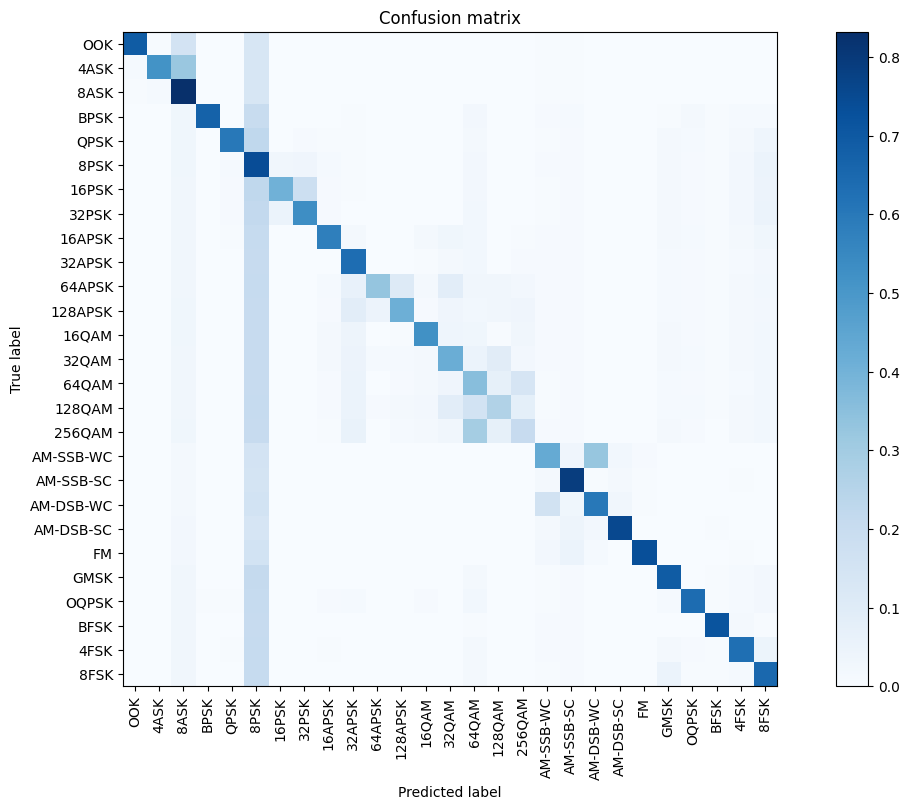

In [65]:
# Plot overall confusion matrix
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=90)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

conf = np.zeros([len(dataset.mod_classes),len(dataset.mod_classes)])
confnorm = np.zeros([len(dataset.mod_classes),len(dataset.mod_classes)])
for i in range(len(y_exp)):
    j = int(y_exp[i])
    k = int(np.argmax(y_pred[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(dataset.mod_classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])

plt.figure(figsize=(12,8))
plot_confusion_matrix(confnorm, labels=dataset.mod_classes)

cor = np.sum(np.diag(conf))
ncor = np.sum(conf) - cor
print("Overall Accuracy across all SNRs: %f"%(cor / (cor+ncor)))

## Confusion Matrix at 4 specific SNRs
Notice how the accuracy is very low at lower SNR and the accuracy is very high at higher SNR

/tmp/ipykernel_167/3267716818.py:22: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(221+plot)


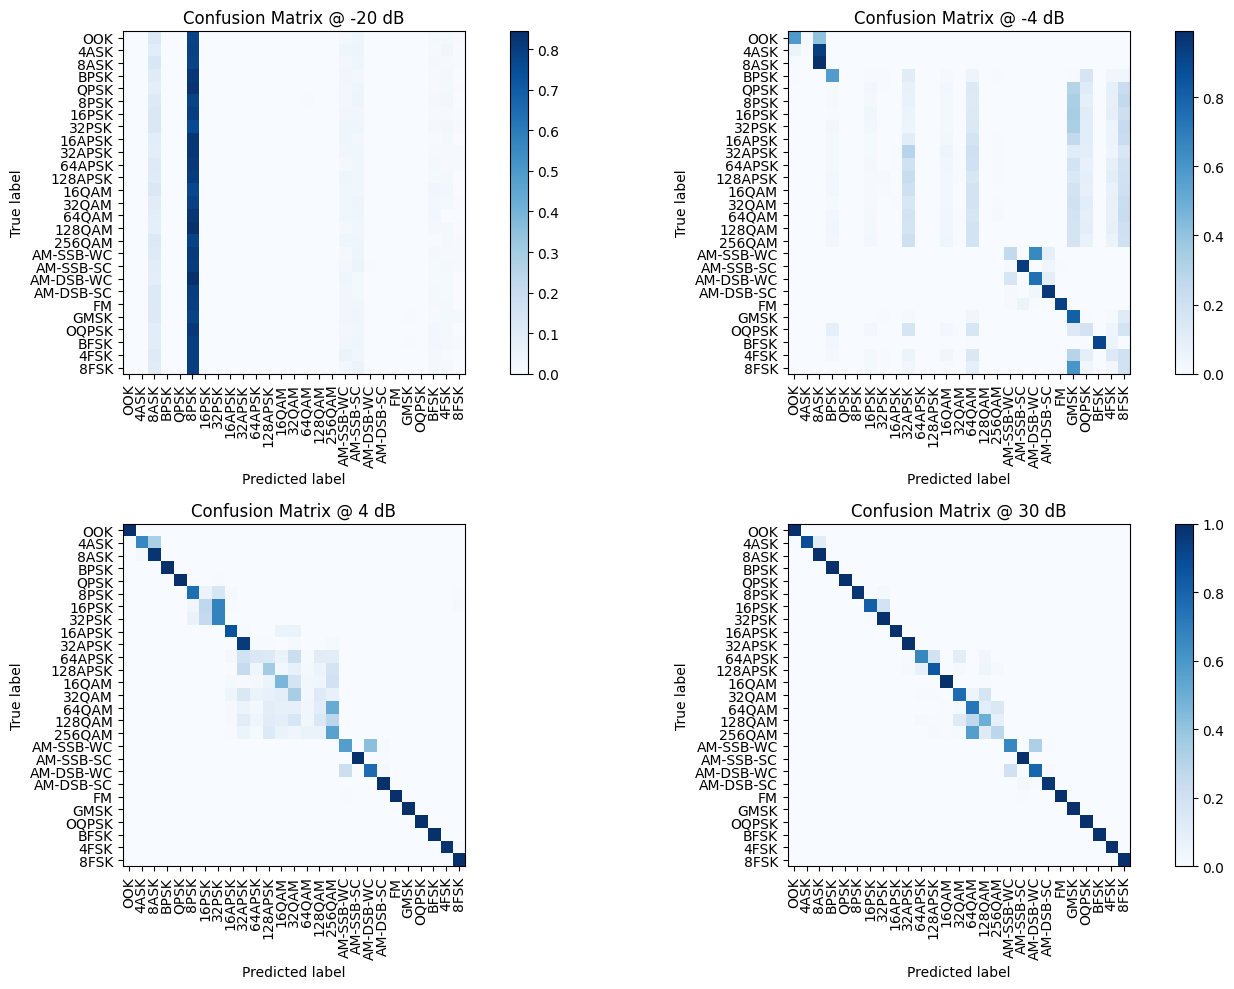

In [66]:
# Plot confusion matrices at 4 different SNRs
snr_to_plot = [-20,-4,+4,+30]
plt.figure(figsize=(16,10))
acc = []
for snr in dataset.snr_classes:
    # extract classes @ SNR
    indices_snr = (y_snr == snr).nonzero()
    y_exp_i = y_exp[indices_snr]
    y_pred_i = y_pred[indices_snr]
 
    conf = np.zeros([len(dataset.mod_classes),len(dataset.mod_classes)])
    confnorm = np.zeros([len(dataset.mod_classes),len(dataset.mod_classes)])
    for i in range(len(y_exp_i)):
        j = int(y_exp_i[i])
        k = int(np.argmax(y_pred_i[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(dataset.mod_classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
 
    if snr in snr_to_plot:
        plot, = np.where(snr_to_plot == snr)[0]
        plt.subplot(221+plot)
        plot_confusion_matrix(confnorm, labels=dataset.mod_classes, title="Confusion Matrix @ %d dB"%(snr))
 
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    acc.append(cor/(cor+ncor))

## Accuracy over SNRs

Accuracy @ highest SNR (+30 dB): 0.883469
Accuracy overall: 0.567553


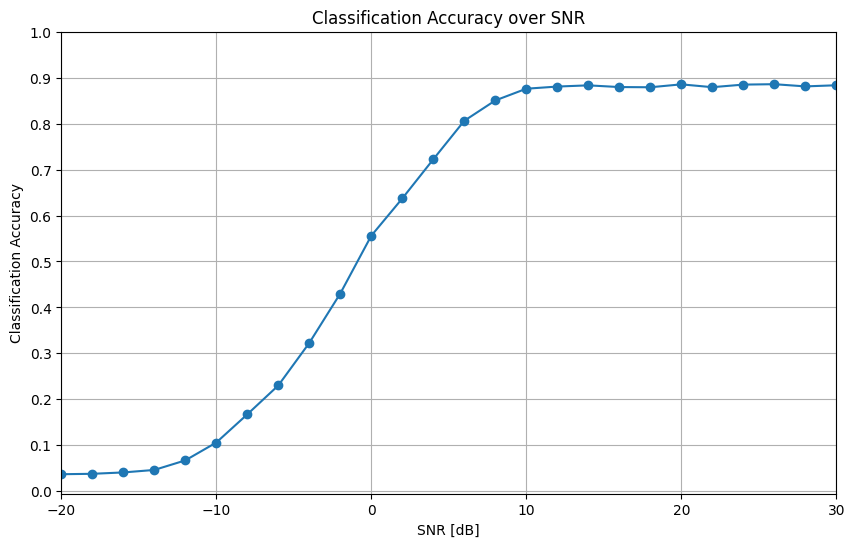

In [67]:
# Plot accuracy over SNR
plt.figure(figsize=(10,6))
plt.plot(dataset.snr_classes, acc, marker='o')
plt.xlabel("SNR [dB]")
plt.xlim([-20, 30])
plt.ylabel("Classification Accuracy")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.title("Classification Accuracy over SNR")
plt.grid()
plt.title("Classification Accuracy over SNR");

print("Accuracy @ highest SNR (+30 dB): %f"%(acc[-1]))
print("Accuracy overall: %f"%(np.mean(acc)))

## Breakdown of the accuracy of each modulations over SNRs

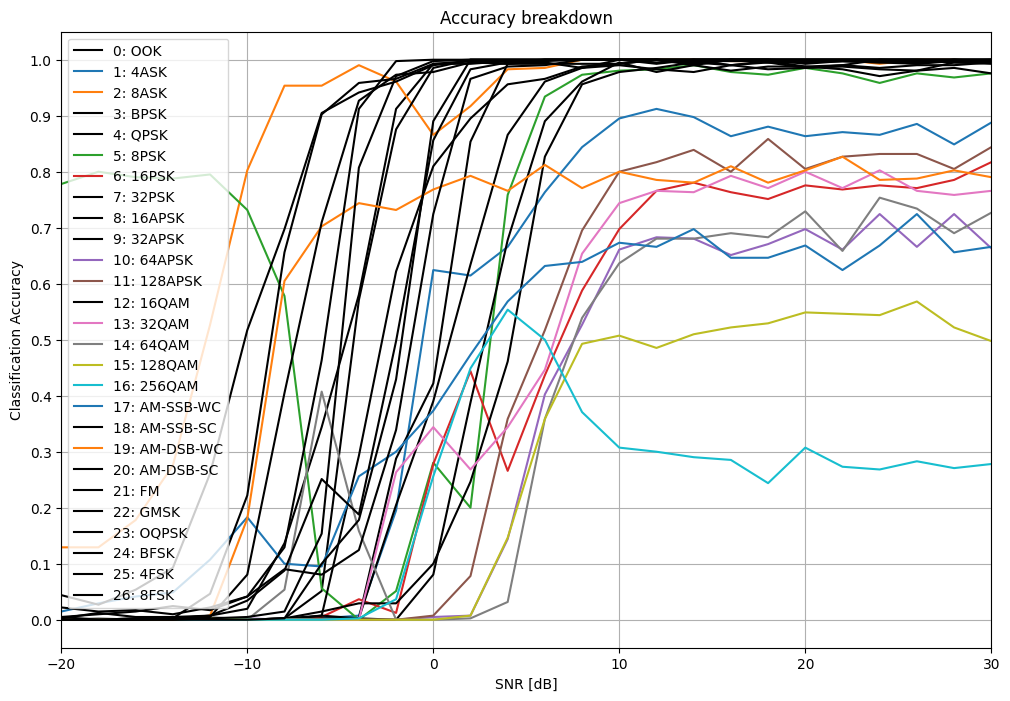

In [68]:
# Plot accuracy per modulation
accs = []
for mod in range((dataset.num_classes)):
    accs.append([])
    for snr in dataset.snr_classes:
        indices = ((y_exp == mod) & (y_snr == snr)).nonzero()
        y_exp_i = y_exp[indices]
        y_pred_i = y_pred[indices]
        cor = np.count_nonzero(y_exp_i == np.argmax(y_pred_i, axis=1))
        accs[mod].append(cor/len(y_exp_i))
        
# Plot accuracy-over-SNR curve
plt.figure(figsize=(12,8))
for mod in range(dataset.num_classes):
    if accs[mod][-1] < 0.95 or accs[mod][0] > 0.1:
        color = None
    else:
        color = "black"
    plt.plot(dataset.snr_classes, accs[mod], label=str(mod) + ": " + dataset.mod_classes[mod], color=color)
plt.xlabel("SNR [dB]")
plt.xlim([-20, 30])
plt.ylabel("Classification Accuracy")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.title("Accuracy breakdown")
plt.grid()
plt.legend();